**Importation des modules**

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import yfinance as yf 
from scipy.stats import norm
import random as random

**On définit des paramètres de simulation pour monte carlo, des horizons pour les périodes étudiés**

In [2]:
n_simulations = 100000  # Nombre de trajectoires Monte Carlo
n_days = 10  # Horizon en jours
confidence_level = 0.99  # Niveau de confiance pour la VaR


**On importe les données historiques**

In [3]:
# Récupération des données historiques entre les dates 2024-01-01 et 2024-12-03
start_date = "2024-01-01"
end_date = "2024-12-03"

# CAC40 et S&P500
cac40 = yf.download("^FCHI", start=start_date, end=end_date,interval='1d')
sp500 = yf.download("^GSPC", start=start_date, end=end_date,interval='1d')


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


**On extrait quelques paramètres pour calculer le prix des options pour le S&P500 et le CAC40**

In [4]:
def get_yield(df):
    assert {'Open', 'Close'}.issubset(df.columns), "Les colonnes 'Open' et 'close' sont manquantes dans le DataFrame"
    df['Spot'] = df['Close']
    df['log_return'] =  np.log(df['Spot'] / df['Spot'].shift(1))
    df = df.dropna(subset = ['log_return'])
    return df
cac40 = get_yield(cac40)
sp500 = get_yield(sp500)

In [5]:
def calc_mu(df) : 
    n = len(df)
    dt = 1/252
    return (1/(n*dt))*(df['log_return'].sum())

def vol(df) : 
    n = len(df)
    dt = 1/252
    nu = calc_mu(df)
    return np.sqrt((1/((n-1)*dt))*((df['log_return']-nu*dt)**2).sum())


sigma_cac = vol(cac40)
sigma_sp = vol(sp500)

S0_cac = cac40['Adj Close'].iloc[-1]
S0_sp = sp500['Adj Close'].iloc[-1]

mu_cac = calc_mu(cac40)
mu_sp = calc_mu(sp500)

**On peut extraire les taux sans-risque**

In [6]:
import yfinance as yf

# Récupération des données pour les bons du Trésor américain à 3 mois (taux sans risque)
us_treasury_data  = yf.Ticker("^IRX").history(period="1d")
r_sp = us_treasury_data['Close'].iloc[-1] / 100 
# On peut noter qu'en règle générale on peut également approximer cette valeur à 5% pour le marché américain 

# Yahoo finance n'offre pas d'info sur le taux sans risque européen, on considérera donc les taux de la BCE en 2024 : 
# On trouve les derniers taux : 23/10/2024;23-oct-24;3.4;2024
r_cac = 0.034

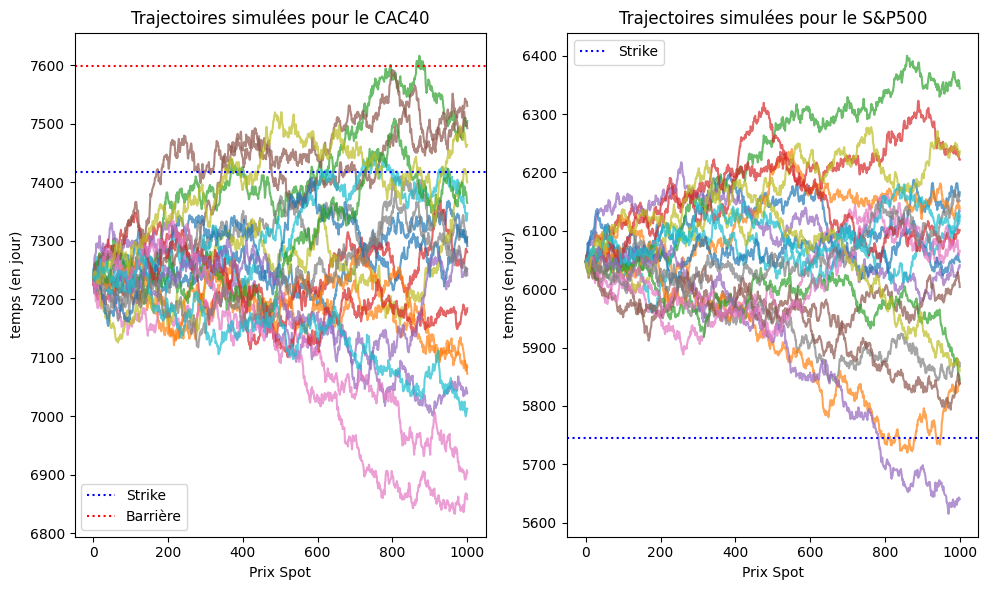

In [7]:
# Fonction pour simuler des trajectoires de prix
import numpy as np

def simulate_spot(S0, sigma, r, n_days, n_simulations, steps_per_day=1):
    dt = 1 / (252 * steps_per_day)  
    n_steps = n_days * steps_per_day  

    prices = np.zeros((n_simulations, n_steps + 1))
    prices[:, 0] = S0

    # Simulation des prix de l'actif sous-jacent
    for t in range(1, n_steps + 1):
        Z = norm.rvs(0, 1, n_simulations)
        prices[:, t] = prices[:, t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

    return prices

# Simulation des prix pour le CAC40 et le S&P500
prices_cac = simulate_spot(S0_cac, sigma_cac, r_cac, n_days, n_simulations, steps_per_day=100)
prices_sp = simulate_spot(S0_sp, sigma_sp, r_sp, n_days, n_simulations, steps_per_day=100)


# On prend volontairement des valeurs de strike et de barrière proche du spot pour observer quelque chose en effet, 
# en 10 jours on ne s'attend pas à une variation importante du prix, si on prend des valeurs trop forte de alpha1, beta1, alpha2
# on n'observera rien
alpha1= 0.05
beta1 = alpha1/2 # Exemple de valeur pour le coef de K1, (On a comme condition K<B sinon le payoff est nul partout)
alpha2= -0.05

K1 = S0_cac*(1+beta1)
B = S0_cac*(1+alpha1)
K2 = S0_sp*(1+alpha2)

# Visualisation de quelques trajectoires

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(prices_cac[:20].T, alpha=0.7, )
plt.axhline(y=K1, color='blue', linestyle=':', label=f"Strike")
plt.axhline(y=B, color='red', linestyle=':', label=f"Barrière")
plt.title("Trajectoires simulées pour le CAC40")
plt.xlabel("Prix Spot")
plt.ylabel("temps (en jour)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(prices_sp[:20].T, alpha=0.7)
plt.axhline(y=K2, color='blue', linestyle=':', label=f"Strike")
plt.title("Trajectoires simulées pour le S&P500")
plt.xlabel("Prix Spot")
plt.ylabel("temps (en jour)")
plt.legend()

plt.tight_layout()
plt.show()


**On définit les expressions explicites de Payoff de manière vectorielle pour calculer les payoffs pour toutes les simulations**

In [8]:
# Payoff : call européen up & out sur CAC40
def call_up_out_payoff(prices, strike, barrier):
    barrier_broken = np.any(prices > barrier, axis=1)
    final_prices = prices[:, -1]
    payoff = np.maximum(final_prices - strike, 0)
    return np.where(barrier_broken, 0, payoff)

# Payoff : put européen sur S&P500
def put_payoff(prices, strike):
    final_prices = prices[:, -1]
    return np.maximum(strike - final_prices, 0)

# Calcul des payoffs
payoff_cac = call_up_out_payoff(prices_cac, K1, B)
payoff_sp = put_payoff(prices_sp, K2)


**On calcule la VaR à 99% en utilisant la fonction percentile de numpy qui nous donne le quantile d'odre 1-0,99 de la distribution**

In [9]:
long_call_cac = 1  
short_put_sp = -1 

# Valeur du portefeuille à l'échéance
portfolio_pnl = long_call_cac * payoff_cac + short_put_sp * payoff_sp
VaR_99 = np.percentile(portfolio_pnl, (1 - confidence_level) * 100)
print(f"La VaR à 99% sur 10 jours est : {VaR_99}")

La VaR à 99% sur 10 jours est : -20.817327763371804
